In [1]:
# builds the connection to azure:
%matplotlib inline

import os
import sys

import numpy as np

import seaborn as sns

# import custom modules:
module_path = os.path.dirname(os.path.abspath(''))
if module_path not in sys.path:
    sys.path.append(module_path)
from common.get_data import *

#set colour palette for seaborn
colors = set_colours()
sns.set_palette(sns.color_palette(colors))
#get engine for sql queries
engine=get_engine()


In [2]:
# get model_version
model_version = pd.read_sql_query('''select value from model_metadata where item = 'model_version' ''', engine)
model_version = model_version.iloc[0][0]
model_version

'v2022.2.3'

## Get Events data

In [3]:
df_events=read_f1k_table()

In [4]:
df_events['year'] = df_events['event_start_date'].dt.year
df_events_byyear = df_events.groupby(['year', 'company_name']).agg({'event_id':'count'}).reset_index()
df_events_byyear.rename({'event_id':'no_events'}, axis='columns', inplace=True)
df_events_byyear['source'] = 'events'

## Get model data

In [5]:
# get model_data
df_model_byyear = pd.read_sql_query('''
    select
        year_x as year,
        run_id::text as company_name,
        count(*)::float as no_events,
        'model' as source
    from 
        model_events
    group by run_id::text, year_x
''', engine)


# Combine event sets

In [6]:
df_byyear = pd.concat([df_events_byyear, df_model_byyear]).reset_index()
df_byyear['no_events'] = df_byyear['no_events'].astype(int)

In [7]:
#summarise count of events per year
df_by_year_summary = df_byyear.groupby(['source','no_events']).agg({'company_name':'count'}).reset_index()
#divide to get the proportion of event count 
df_by_year_summary = df_by_year_summary.pivot_table(index=['no_events'], values='company_name', columns='source')
df_by_year_summary = (df_by_year_summary/df_by_year_summary.sum()).fillna(0).reset_index()

## Plot the result

In [8]:
#re-structure to present to plot
df_by_year_summary_melt = df_by_year_summary.melt(id_vars='no_events').set_index('no_events').reset_index()

Text(0.5, 1.0, 'v2022.2.3')

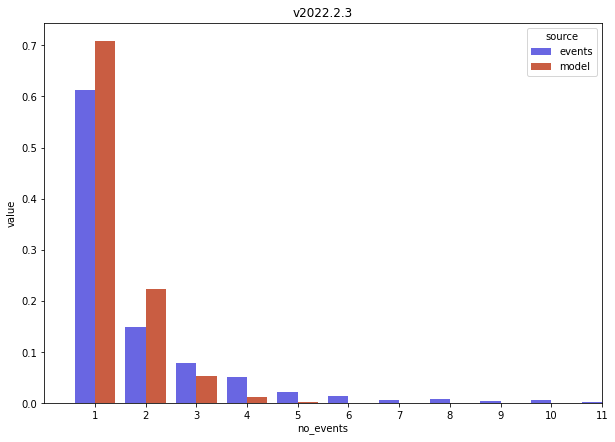

In [9]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
sns.barplot(data=df_by_year_summary_melt, x='no_events', y='value',hue='source', ax=ax)
ax.set_xlim(-1,10)
ax.set_title(model_version)